# Training GAUDI on Watts-Strogatz Small-World Graphs

This notebook runs GAUDI on Watts-Strogatz small-world graphs. We begin by defining a function to generate Watts-Strogatz graphs and then create a corresponding dataloader. Next, we load GAUDI and set its parameters. Finally, we train the model and analyze the resulting latent space.

In [1]:
import deeplay as dl

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pygsp import graphs
import random
from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data

from components import GraphEncoder, GraphDecoder
from applications import VariationalGraphAutoEncoder

To ensure reproducibility of this notebook, we set a fixed seed for random number generation.

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Generate Watts-Strogatz graphs

We generate Watts-Strogatz small-world graphs with 80 nodes each. The node degree `c` is randomly set to 2, 4, 6, or 8, and the rewiring probability `p` is randomly selected from the interval [0, 1). 

We normalize the node positions by centering them around (0,0) and normalizing them using the standard deviation. Node features are defined as the inverse distance to the graph’s center. Edge features are computed as the inverse length of the edges, where edge lengths are determined by the Euclidean distance between connected nodes.

The conditional statement `return_p_c` determines whether the function returns the used parameters (p and c). During training, we generate graphs without saving these parameters, as they are not needed. However, for the test data, we retain them to enable analysis of the obtained latent space.

In [3]:
def generate_WS_graph(return_p_c = False):
    num_nodes = 80
    G = graphs.Ring(N = num_nodes)
    X = G.coords
    X = torch.from_numpy(X)

    p = torch.rand(1)
    c = torch.randint(1, 5, (1,)) * 2

    G = nx.watts_strogatz_graph(num_nodes, c, p)
    A = nx.adjacency_matrix(G).todense()
    A = torch.from_numpy(A) * 1.0

    # normalize X and put center of mass around (0,0)
    mean = torch.mean(X, dim=0)
    std = torch.std(X, dim=0, unbiased=False)
    X = (X - mean)/std

    # node features: (inverse distance to center of the graph)
    node_features = 1/torch.norm(X, dim=1)
    node_features = node_features.reshape((-1, 1))
    node_features = node_features.type(torch.float32)

    # edge features: (inverse length of the edges)
    edge_index = A.nonzero(as_tuple=False).T
    
    edge_features = 1 / torch.norm(X[edge_index[0]] - X[edge_index[1]], dim=1)
    edge_features = edge_features.reshape((-1,1))
    edge_features = edge_features.type(torch.float32)

    if return_p_c == True:
        return node_features, edge_features, edge_index, p, c, num_nodes
    
    else:
        return node_features, edge_features, edge_index

Get the node features, edge features and the edge indices for a sample graph:

In [4]:
n_f, e_f, edge_ind = generate_WS_graph()

Next, we create a custom dataset `WattsStrogatzDataset` and a corresponding `Dataloader`.

In [5]:
class WattsStrogatzDataset(Dataset):
    def __init__(self, dataset_size, generate_graph_fn, train):
        self.dataset_size = dataset_size
        self.generate_graph_fn = generate_graph_fn  # Func to generate WS graph
        self.train = train

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):

        if self.train:
            # Generate a new WS graph for each sample
            n_f, e_f, edge_ind = self.generate_graph_fn()

            # Create the graph data object using all nodes and edges
            graph = Data(
                x=n_f, 
                edge_index=edge_ind, 
                edge_attr=e_f,
                y=[n_f, e_f],
            )

        
        else:
            n_f, e_f, edge_ind, p, c, num_nodes = self.generate_graph_fn(
                                                            return_p_c=True
                                                            )

            graph = Data(
                x=n_f, 
                edge_index=edge_ind, 
                edge_attr=e_f,
                p=p,
                c=c,
                n=num_nodes,
                y=[n_f, e_f],
            )


        return graph

train_dataset = WattsStrogatzDataset(
    dataset_size=200,
    generate_graph_fn=generate_WS_graph,
    train=True
)

In [6]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 

C:\Users\xgrmir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Setting parameters and loading GAUDI

Now that we have out graph dataset set up, we proceed by configuring the parameters for GAUDI. After defining the parameters, we define GAUDI by first defining the encoder and the decoder, and then calling a `VariationalGraphAutoEncoder` using this encoder and decoder.

In [7]:
num_clusters = [20, 5, 1]               # number of clusters in the 
                                        # mincut pooling
thresholds = [1/19, 1/5, None]          # threshold for binarizing the 
                                        # adjacency matrices
hidden_dim = 96
latent_dim = 8
num_blocks = 3
variational = True

n_features = n_f.shape[1]               # number of node features
e_features = e_f.shape[1]               # number of edge attributes


alpha = 0               # weight of reconstruction loss for the node features
beta = 1e-5             # weight of KL-loss
gamma = 10              # weight of reconstruction loss for the edge attributes
delta = 1               # weight of MinCut loss

learning_rate = 5e-5 

In [8]:
encoder = GraphEncoder(
    hidden_features=hidden_dim,
    num_blocks=num_blocks,
    num_clusters = num_clusters,
    thresholds=thresholds
    )

decoder = GraphDecoder(
    hidden_features=hidden_dim,
    num_blocks=num_blocks,
    output_node_dim = n_features,
    output_edge_dim=e_features
    )

vgae = VariationalGraphAutoEncoder(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    optimizer = dl.Adam(lr=learning_rate),
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    delta=delta,
    )

print(vgae)

VariationalGraphAutoEncoder(
  (encoder): GraphEncoder(
    (message_passing): MessagePassingNeuralNetworkSender(
      (blocks): LayerList(
        (0-1): 2 x TransformPropagateUpdate(
          (transform): TransformSender(
            (combine): Cat()
            (layer): Layer[LazyLinear](out_features=96)
            (activation): Layer[ReLU]()
          )
          (propagate): Mean()
          (update): Update(
            (combine): Cat()
            (layer): Layer[LazyLinear](out_features=96)
            (activation): Layer[ReLU]()
          )
        )
      )
    )
    (dense): Layer[Linear](in_features=96, out_features=96)
    (activate): Layer[ReLU]()
    (blocks): LayerList(
      (0): GraphEncoderBlock(
        (gcn): GraphConvolutionalNeuralNetworkConcat(
          (normalize): Layer[sparse_laplacian_normalization]()
          (blocks): LayerList(
            (0): TransformPropagateUpdate(
              (transform): Layer[Linear](in_features=96, out_features=96)
        

Let's build the variational graph autoencoder, and try it on the first batch of the `train_loader`.

In [9]:
for i, batch in enumerate(train_loader):
    if i == 0:
        print('The batch holds the following keys:', batch)
        break

VGAE = vgae.build()
out = VGAE(batch)
print('The output of the model holds the following keys:', out)

The batch holds the following keys: DataBatch(x=[80, 1], edge_index=[2, 640], edge_attr=[640, 1], y=[2], batch=[80], ptr=[2])
The output of the model holds the following keys: DataBatch(x=[80, 1], edge_index=[2, 640], edge_attr=[640, 1], y=[2], batch=[80], ptr=[2], input_edge_index=[2, 640], input_edge_attr=[640, 1], aggregate=[80, 96], x_prime=[80, 96], s_0=[80, 20], batch_1=[20], L_cut_0=-0.999983012676239, L_ortho_0=1.2461051940917969, edge_index_1=[20, 20], s_1=[20, 5], batch_2=[5], L_cut_1=-0.9782609939575195, L_ortho_1=1.0461658239364624, edge_index_2=[5, 5], s_2=[5, 1], batch_3=[1], edge_index_3=[1, 1], mu=[1, 8], log_var=[1, 8], z=[1, 8], edge_attr_sender=[640, 96], edge_attr_receiver=[640, 96])


### Train GAUDI

In [10]:
trainer = dl.Trainer(max_epochs=5) 
trainer.fit(VGAE, train_loader)

C:\Users\xgrmir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                ┃ Type             ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ encoder             │ GraphEncoder     │  151 K │
│ 1  │ fc_mu               │ Linear           │    776 │
│ 2  │ fc_var              │ Linear           │    776 │
│ 3  │ fc_dec              │ Linear           │    864 │
│ 4  │ decoder             │ GraphDecoder     │  148 K │
│ 5  │ reconstruction_loss │ L1Loss           │      0 │
│ 6  │ train_metrics       │ MetricCollection │      0 │
│ 7  │ val_metrics         │ MetricCollection │      0 │
│ 8  │ test_metrics        │ MetricCollection │      0 │
│ 9  │ reparameterize      │ Reparameterize   │      0 │
│ 10 │ optimizer           │ Adam             │      0 │
└────┴─────────────────────┴──────────────────┴────────┘

Trainable params: 302 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 302 K                                                                                                
Total estimated model params size (MB): 1

Output()

C:\Users\xgrmir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


### Plotting the obtained latent space

To visualize the learned latent representation of GAUDI, we first create a `test_dataset` with Watts-Strogatz graphs and a corresponding dataloader. Then the latent space positions of these graphs are calculated using GAUDI. Lastly, we apply a principal component analysis, to plot the first two principal components of the latent space positions.

In [11]:
test_size = 350

test_dataset = WattsStrogatzDataset(
    dataset_size=test_size,
    generate_graph_fn=generate_WS_graph,
    train=False
)

test_batch_size = 1
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True
    )

C:\Users\xgrmir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
z = np.zeros((test_size, latent_dim))
p = np.zeros((test_size,))
c = np.zeros((test_size,))

for i, batch in enumerate(test_loader):
    out = VGAE(batch)
    
    z[i*test_batch_size:(i+1)*test_batch_size, :] = out['mu'].detach().numpy()
    p[i*test_batch_size:(i+1)*test_batch_size] = out['p'].detach().numpy()
    c[i*test_batch_size:(i+1)*test_batch_size] = out['c'].detach().numpy()

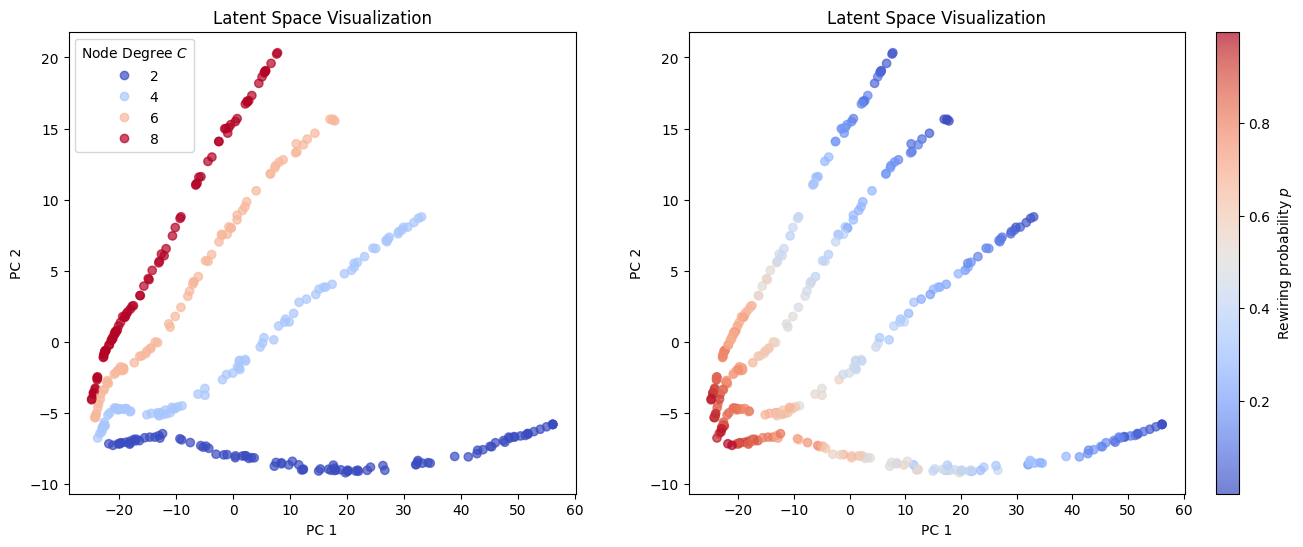

In [13]:
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z)

fig, axes = plt.subplots(
    1,
    2,
    figsize=(16, 6),
    gridspec_kw={'width_ratios': [0.45, 0.55]},
    )

scatter1 = axes[0].scatter(
    z_2d[:, 0],
    z_2d[:, 1],
    c=c,
    cmap='coolwarm',
    alpha=0.7)
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
axes[0].set_title("Latent Space Visualization")
handles, labels = scatter1.legend_elements()
axes[0].legend(handles, labels, title="Node Degree $C$", loc='upper left')

scatter2 = axes[1].scatter(
    z_2d[:, 0],
    z_2d[:, 1],
    c=p,
    cmap='coolwarm', 
    alpha=0.7,
    )
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")
axes[1].set_title("Latent Space Visualization")
fig.colorbar(scatter2, ax=axes[1], label='Rewiring probability $p$')